# Part b. Beta bins.

In [46]:
import sys
import os
def find_code_dir():
    current_dir = os.path.abspath('')
    while current_dir:
        if os.path.basename(current_dir) == 'code':
            return current_dir
        current_dir = os.path.dirname(current_dir)
    raise Exception("Could not find the 'code' directory")
code_dir = find_code_dir()
functions_dir = os.path.join(code_dir, 'functions')  # import from functions
sys.path.append(functions_dir)

# Make sure have __init__.py
init_file = os.path.join(functions_dir, '__init__.py')
open(init_file, 'a').close()

from function_lib import *
import warnings
warnings.filterwarnings("ignore")
plt.rc('figure', figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import constant as c   # constant module
data = pd.read_csv('hw2_data.csv')

# Feature Engineering
# data = data.dropna(subset=['date', 'ticker', 'f_ols_1y_d'])
data = data.drop(columns=['ask', 'bid']) # too many NA
data = data.dropna()
data[c.DATE] = pd.to_datetime(data[c.DATE])

In [48]:
data.head(10)

,permno,date,ticker,log_size,log_bm,log_pcf,mom,strev,vol,roa,roe,log_age_lb,price,log_to,rf,rm,ols_3m_d,ols_1y_d,ols_5y_m,f_ols_1y_d
1,10006,1970-02-27,ACF,5.603962,-0.229413,2.962434,-0.162378,0.051272,0.065000,0.157,0.099,3.788477,48.125,15.291317,0.006098,0.057959,0.629034,0.890264,1.079448,0.707153
14,10006,1971-03-31,ACF,5.657040,-0.057629,1.885857,0.006501,0.090912,0.064180,0.146,0.079,3.812793,51.000,16.048520,0.002994,0.044601,1.013018,0.725313,1.032993,0.910294
15,10006,1971-04-30,ACF,5.806941,-0.057629,1.885857,0.172713,0.161765,0.064451,0.146,0.079,3.814606,59.250,15.975864,0.002734,0.034258,1.659454,0.742850,1.050250,0.866626
16,10006,1971-05-31,ACF,5.743964,-0.366725,2.059621,0.473181,-0.050964,0.064224,0.146,0.089,3.816477,55.625,15.781538,0.003004,-0.037063,1.554877,0.686803,1.055927,0.881395
17,10006,1971-06-30,ACF,5.737217,-0.366725,2.059621,0.420872,-0.006742,0.064000,0.146,0.089,3.818284,55.250,15.704612,0.003747,0.003666,0.711878,0.496517,1.069211,0.931619
18,10006,1971-07-30,ACF,5.639777,-0.366725,2.059621,0.427179,-0.092759,0.064067,0.146,0.089,3.820088,50.125,16.326793,0.003998,-0.041327,0.600989,0.600127,1.077319,0.882747
19,10006,1971-08-31,ACF,5.781361,-0.449417,2.097159,0.275602,0.164039,0.064279,0.146,0.076,3.822008,57.750,16.184775,0.004630,0.039698,1.143163,0.828250,1.046442,0.678192
20,10006,1971-09-30,ACF,5.774862,-0.449417,2.097159,0.336800,-0.006493,0.063582,0.146,0.076,3.823805,57.375,14.803247,0.003576,-0.004876,1.194123,0.799344,1.071377,0.714999
21,10006,1971-10-29,ACF,5.657040,-0.449417,2.097159,0.371591,-0.111113,0.062791,0.146,0.076,3.825540,51.000,14.765507,0.003576,-0.040533,1.211499,0.965747,1.087674,0.633466
22,10006,1971-11-30,ACF,5.614587,-0.487760,1.930216,0.164711,-0.029369,0.062877,0.146,0.074,3.827450,48.875,15.818926,0.003787,-0.000871,0.802211,1.005503,1.089968,0.503910


In [49]:
ret_cols = 'ret'
signal_col = 'f_ols_1y_d'
data.sort_values(c.DATE, inplace=True)
data[ret_cols] = data.groupby(c.SEC_ID)[c.PRICE].transform(lambda x: x.pct_change())
data.dropna(subset=[ret_cols], inplace=True)
data = data.reset_index(drop=True)

1. Portfolio with historical beta.

In [50]:
def get_quantile_returns(frame, signal_col, n_bins=10, ret='ret_1p'):
    frame[f'{signal_col}Group'] = pd.qcut(frame[signal_col], n_bins, labels=[i + 1 for i in range(n_bins)])
    return frame.groupby(f'{signal_col}Group')[ret].mean()

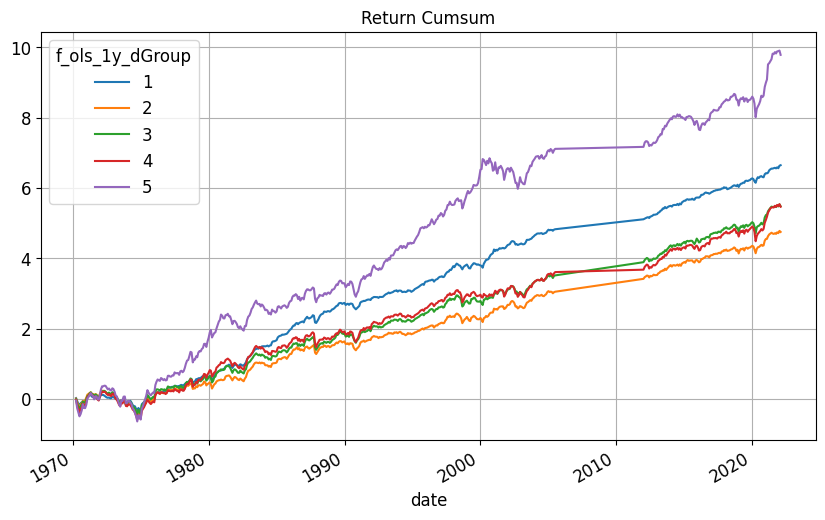

In [51]:
n_bins = 5
portfolio_returns = data.groupby(c.DATE).apply(get_quantile_returns, signal_col=signal_col, n_bins=n_bins, ret=ret_cols).iloc[:-1,]
portfolio_returns.cumsum().plot(figsize=(10, 6), title='Return Cumsum')
plt.grid(True)
plt.show()

In [52]:
print('Portfolio raw return:')
display(round(portfolio_returns.cumsum().iloc[-1, :], 2))

Portfolio raw return:


f_ols_1y_dGroup
1    6.65
2    4.75
3    5.48
4    5.47
5    9.79
Name: 2022-01-31 00:00:00, dtype: float64

In [53]:
portfolio_returns['spread'] = portfolio_returns[n_bins] - portfolio_returns[1]

In [54]:
filter_dates = portfolio_returns.index.strftime('%Y%m')

In [55]:
# FF-data
ff_factors = pd.read_csv("/Users/yihan/Desktop/code/MFE230S/24_HW1/F-F_Research_Data_Factors.CSV", header=2, index_col=0).iloc[:-1,]
ff_factors = ff_factors[ff_factors.index.isin(filter_dates)].astype('float')
portfolio_returns[["RmMinusRf", "smb", "hml", "rf"]] = ff_factors[["Mkt-RF", "SMB", "HML", "RF"]].values / 100

In [56]:
portfolio_returns

f_ols_1y_dGroup,1,2,3,4,5,spread,RmMinusRf,smb,hml,rf
date,,,,,,,,,,
1970-03-31,0.024149,0.009182,-0.008134,-0.024194,-0.046561,-0.070711,-0.0106,-0.0232,0.0399,0.0057
1970-04-30,-0.084143,-0.103904,-0.119795,-0.164023,-0.216361,-0.132218,-0.1100,-0.0615,0.0618,0.0050
1970-05-29,-0.071819,-0.093506,-0.089473,-0.099776,-0.110995,-0.039177,-0.0692,-0.0459,0.0333,0.0053
1970-06-30,-0.034859,-0.040361,-0.064802,-0.088580,-0.120025,-0.085166,-0.0579,-0.0213,0.0060,0.0058
1970-07-31,0.044122,0.069661,0.077641,0.087402,0.064048,0.019926,0.0693,-0.0050,0.0090,0.0052
...,...,...,...,...,...,...,...,...,...,...
2021-09-30,-0.016884,-0.017620,-0.026461,-0.031101,-0.037039,-0.020155,-0.0437,0.0071,0.0508,0.0000
2021-10-29,0.029311,0.043860,0.047306,0.055819,0.059500,0.030189,0.0665,-0.0235,-0.0049,0.0000
2021-11-30,-0.025922,-0.023024,-0.028466,-0.033442,0.005508,0.031429,-0.0155,-0.0132,-0.0045,0.0000


## CAPM Alpha & Beta for quantile portfolios

In [57]:
# CAPM results calculation
capm_results = []
for group in range(1, n_bins + 1):
    dependent_var = portfolio_returns[group] - portfolio_returns['rf']
    independent_var = sm.add_constant(portfolio_returns["RmMinusRf"])
    model = sm.OLS(dependent_var, independent_var).fit()
    capm_results.append([model.params[0], model.bse[0], model.params[1], model.bse[1]])

pd.DataFrame(capm_results, columns=[["CAPM alpha", "alpha_std", "beta", "beta_std"]]).round(3)

,CAPM alpha,alpha_std,beta,beta_std
0,0.004,0.001,0.584,0.025
1,-0.001,0.001,0.825,0.026
2,-0.001,0.001,1.001,0.028
3,-0.002,0.001,1.184,0.022
4,0.003,0.002,1.655,0.039


## Quantile spread Stats

Quantile portfolio spread:
capm_alpha : -0.005
capm_t_stat : -2.489
ff_alpha : -0.004
ff_t_stat : -2.002
Ann_return : 0.02
Ann_sharpe : 0.092


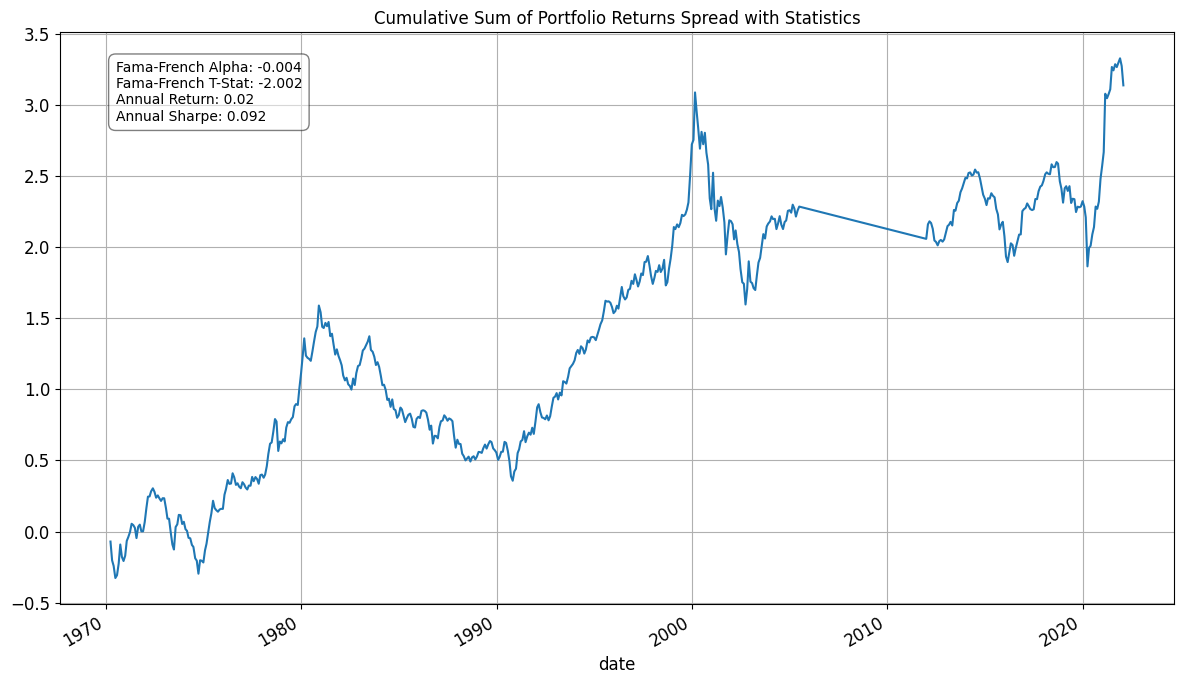

In [58]:
results = {}  # total result
# CAPM on spread
portfolio_returns['spread'] = portfolio_returns[n_bins] - portfolio_returns[1]
independent_var = sm.add_constant(portfolio_returns["RmMinusRf"])
capm_regression = sm.OLS(portfolio_returns['spread'] - portfolio_returns['rf'], independent_var).fit()
results['capm_alpha'] = capm_regression.params[0]
results['capm_t_stat'] = capm_regression.tvalues[0]

# Fama-French alpha
independent_var = sm.add_constant(portfolio_returns[["RmMinusRf", "smb", "hml"]])
ff_regression = sm.OLS(portfolio_returns['spread'] - portfolio_returns['rf'], independent_var).fit()
results['ff_alpha'] = ff_regression.params[0]
results['ff_t_stat'] = ff_regression.tvalues[0]

results['Ann_return'] = np.mean(portfolio_returns['spread']) * np.sqrt(12)  # ann return
results['Ann_sharpe'] = (np.mean(portfolio_returns['spread']) - np.mean(portfolio_returns['rf'])) / np.std(portfolio_returns['spread']) * np.sqrt(12)

print('Quantile portfolio spread:')
for key, value in results.items():
    print(f'{key} : {round(value, 3)}')

# Plot cumulative sum of portfolio returns spread with results statistics
fig, ax = plt.subplots(figsize=(12, 7))  # Single subplot for both the plot and statistics

# Plotting the cumulative sum of portfolio returns spread
portfolio_returns['spread'].cumsum().plot(ax=ax)
ax.grid(True)
ax.set_title("Cumulative Sum of Portfolio Returns Spread with Statistics")

# Define box with results stats to display on the plot
box_stats = {
    'Fama-French Alpha': np.round(results['ff_alpha'], 3),
    'Fama-French T-Stat': np.round(results['ff_t_stat'], 3),
    'Annual Return': np.round(results['Ann_return'], 3),
    'Annual Sharpe': np.round(results['Ann_sharpe'], 3)
}

# Formatting the text string to display statistics
text_str = "\n".join([f"{k}: {v}" for k, v in box_stats.items()])
# Positioning the text box on the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

Consider now the τ−months horizon 'beta Momentum' strategy: at month t, each stock is allocated to one of quantile portfolios based on their month-t historical beta; in month t+τ, strategy goes long stocks in the top decile and short stocks in the bottom decile. The portfolio is rebalanced monthly.

- If momentum is due to investors under-reacting to profit news, we check the returns on the τ−month horizon momentum strategy. What if instead momentum is driven by investors’ over-reaction to news?

- Plot a graph that shows the FF α and the t-statistics on this α of the τ-month horizon momentum strategy as a function of the horizon τ. 

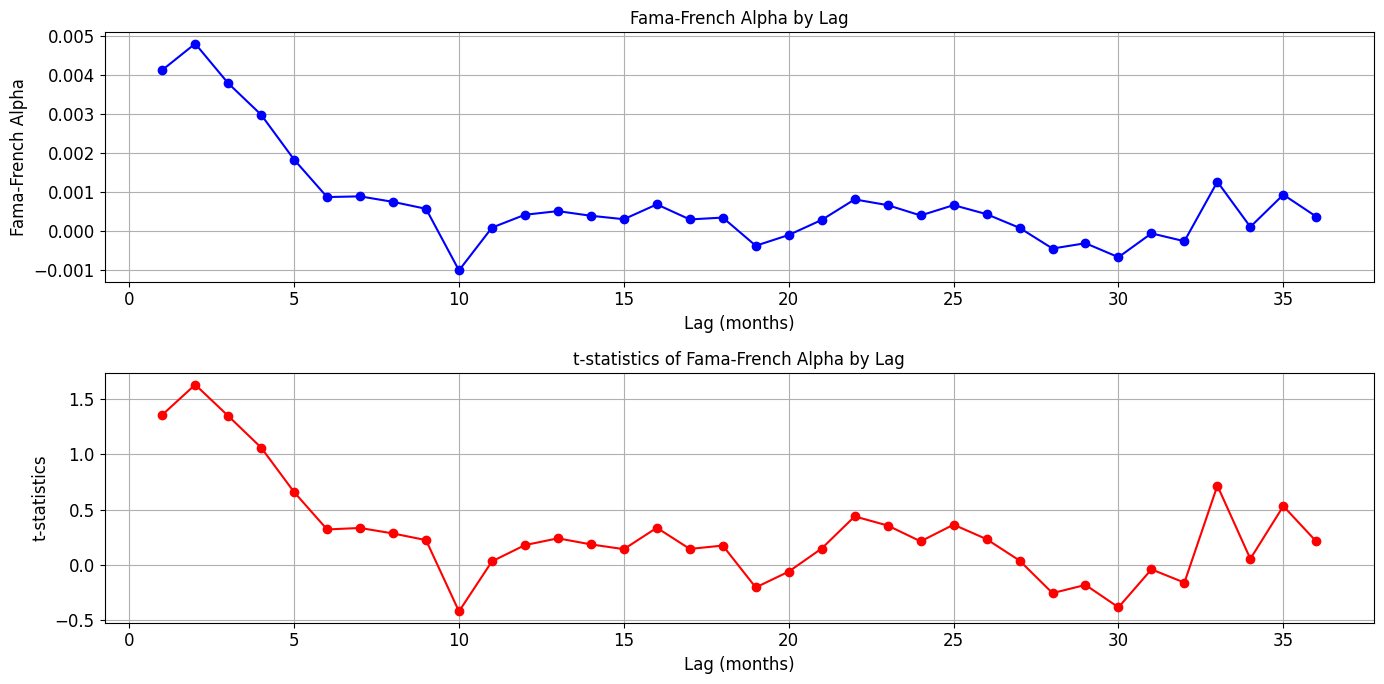

In [59]:
results_list = []

for lag in range(1, 37):
    # Forward target variables
    data[f'ret_p{lag}'] = data.groupby(c.SEC_ID)[ret_cols].shift(-lag)
    # Make sure no nan, when lag, less data
    portfolio_returns = data.groupby(c.DATE).apply(get_quantile_returns, signal_col=signal_col, n_bins=n_bins, ret=f'ret_p{lag}').iloc[:-lag,]
    portfolio_returns[["RmMinusRf", "smb", "hml", "rf"]] = ff_factors[["Mkt-RF", "SMB", "HML", "RF"]].values[:len(portfolio_returns)] / 100
    portfolio_returns['spread'] = portfolio_returns[n_bins] - portfolio_returns[1]
    independent_var = sm.add_constant(portfolio_returns[["RmMinusRf", "smb", "hml"]])
    ff_regression = sm.OLS(portfolio_returns['spread'] - portfolio_returns['rf'], independent_var).fit()
    
    results_dict = {
        'Lag': lag,
        'FF_Alpha': ff_regression.params[0],
        'FF_t_stat': ff_regression.tvalues[0],
        'Ann_return': np.mean(portfolio_returns['spread']) * np.sqrt(12),  # annualized return
        'Ann_sharpe': (np.mean(portfolio_returns['spread']) - np.mean(portfolio_returns['rf'])) / np.std(portfolio_returns['spread']) * np.sqrt(12)
    }
    results_list.append(results_dict)

summary_df = pd.DataFrame(results_list)

# Plotting the graph for FF Alpha and t-statistics
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(summary_df['Lag'], summary_df['FF_Alpha'], marker='o', linestyle='-', color='blue')
plt.title('Fama-French Alpha by Lag')
plt.xlabel('Lag (months)')
plt.ylabel('Fama-French Alpha')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(summary_df['Lag'], summary_df['FF_t_stat'], marker='o', linestyle='-', color='red')
plt.title('t-statistics of Fama-French Alpha by Lag')
plt.xlabel('Lag (months)')
plt.ylabel('t-statistics')
plt.grid(True)

plt.tight_layout()
plt.show()

In [60]:
summary_df

,Lag,FF_Alpha,FF_t_stat,Ann_return,Ann_sharpe
0,1,0.004116,1.358333,0.027872,0.207904
1,2,0.004792,1.631838,0.026256,0.189985
2,3,0.003777,1.349083,0.021420,0.121799
3,4,0.002970,1.062131,0.020406,0.106930
4,5,0.001819,0.659328,0.018266,0.073767
...,...,...,...,...,...
31,32,-0.000272,-0.160311,0.012391,-0.051007
32,33,0.001252,0.717399,0.015916,0.042245
33,34,0.000095,0.054877,0.014870,0.014678
34,35,0.000921,0.532663,0.016142,0.047900
